In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import re
import string
import pandas as pd
import nltk
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from nltk.corpus import stopwords

In [0]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


In [0]:
def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [0]:
def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [0]:
def getEmbeddings(path,vector_dimension=300):
    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels

In [7]:
!pip install scikit-plot

In [0]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

In [0]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
xtr,xte,ytr,yte = getEmbeddings("/content/drive/My Drive/train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [0]:
xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

In [0]:
gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

Accuracy = 72.43%


In [0]:
from sklearn import metrics
print("The accuracy score of naive bayes is",metrics.accuracy_score(yte, y_pred.round()))
print("The precision score of naive bayes is",metrics.precision_score(yte, y_pred.round()))
print("The recall score of naive bayes is",metrics.recall_score(yte, y_pred.round()))
print("The f1-score of naive bayes is",metrics.f1_score(yte, y_pred.round()))

The accuracy score of naive bayes is 0.7242956898627498
The precision score of naive bayes is 0.6808270676691729
The recall score of naive bayes is 0.859515899383009
The f1-score of naive bayes is 0.7598070065030418


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


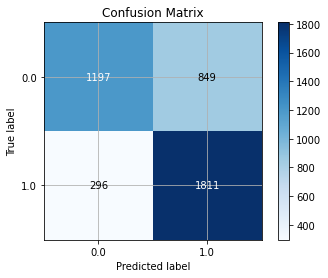

In [0]:
plot_cmat(yte, y_pred)

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC()
clf.fit(xtr, ytr)
y_pred1 = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred1).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%") 

Accuracy = 91.55%


In [0]:
from sklearn import metrics
print("The accuracy score of SVM is",metrics.accuracy_score(yte, y_pred1.round()))
print("The precision score of SVM is",metrics.precision_score(yte, y_pred1.round()))
print("The recall score of SVM is",metrics.recall_score(yte, y_pred1.round()))
print("The f1-score of SVM is",metrics.f1_score(yte, y_pred1.round()))

The accuracy score of SVM is 0.9154827835299784
The precision score of SVM is 0.9072356215213359
The recall score of SVM is 0.9283341243474134
The f1-score of SVM is 0.9176636171710064


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


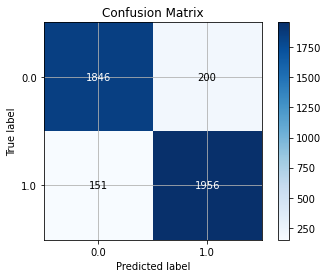

In [0]:
plot_cmat(yte, y_pred1)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf = RandomForestClassifier()
clf.fit(xtr, ytr)
y_pred2 = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred2).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

Accuracy = 88.35%


In [0]:
from sklearn import metrics
print("The accuracy score of random forest is",metrics.accuracy_score(yte, y_pred2.round()))
print("The precision score of random forest is",metrics.precision_score(yte, y_pred2.round()))
print("The recall score of random forest is",metrics.recall_score(yte, y_pred2.round()))
print("The f1-score of random forest is",metrics.f1_score(yte, y_pred2.round()))

The accuracy score of random forest is 0.883457741391765
The precision score of random forest is 0.8968215158924205
The recall score of random forest is 0.8704318936877077
The f1-score of random forest is 0.8834296724470135


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


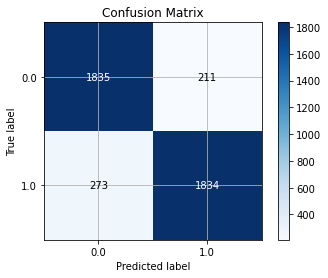

In [0]:
plot_cmat(yte, y_pred2)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt

Using TensorFlow backend.


In [0]:
def baseline_model():
  model = Sequential()
  model.add(Dense(128,input_dim= 300,activation='relu',use_bias=True))
  model.add(Dropout(0.1))
  #model.add(Dense(128,activation='relu',use_bias=True))
  #model.add(Dropout(0.1))
  model.add(Dense(64,activation='relu',use_bias=True))
  model.add(Dropout(0.1))
  model.add(Dense(32,activation='relu',use_bias=True))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='sigmoid',use_bias=True)) 
  return model

model = baseline_model()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
x_train=xtr;
y_train=ytr;
x_test=xte;
y_test=yte;

#x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
label_encoder.fit(y_test)
y_test = label_encoder.transform(y_test)
estimator = model.fit(x_train,y_train, epochs=25, batch_size=64 ,verbose=1 , shuffle=True)
print("Model Trained!")
score = model.evaluate(x_test,y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")  

y_pred3 = model.predict(x_test)
 

Epoch 1/25
16608/16608 [==============================] - 1s 56us/step - loss: 0.1611 - accuracy: 0.9373
Epoch 2/25
16608/16608 [==============================] - 1s 55us/step - loss: 0.1210 - accuracy: 0.9535
Epoch 3/25
16608/16608 [==============================] - 1s 52us/step - loss: 0.0985 - accuracy: 0.9630
Epoch 4/25
16608/16608 [==============================] - 1s 54us/step - loss: 0.0847 - accuracy: 0.9672
Epoch 5/25
16608/16608 [==============================] - 1s 54us/step - loss: 0.0828 - accuracy: 0.9681
Epoch 6/25
16608/16608 [==============================] - 1s 60us/step - loss: 0.0729 - accuracy: 0.9730
Epoch 7/25
16608/16608 [==============================] - 1s 62us/step - loss: 0.0714 - accuracy: 0.9736
Epoch 8/25
16608/16608 [==============================] - 1s 52us/step - loss: 0.0667 - accuracy: 0.9757
Epoch 9/25
16608/16608 [==============================] - 1s 56us/step - loss: 0.0667 - accuracy: 0.9769
Epoch 10/25
16608/16608 [==============================

In [0]:
from sklearn import metrics
print("The accuracy score of deep neural network is",metrics.accuracy_score(y_test, y_pred3.round()))
print("The precision score of deep neural network is",metrics.precision_score(y_test, y_pred3.round()))
print("The recall score of deep neural network is",metrics.recall_score(y_test, y_pred3.round()))
print("The f1-score of deep neural network is",metrics.f1_score(y_test, y_pred3.round()))

The accuracy score of deep neural network is 0.9229472670358777
The precision score of deep neural network is 0.9196806012212306
The recall score of deep neural network is 0.9292833412434741
The f1-score of deep neural network is 0.9244570349386213


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


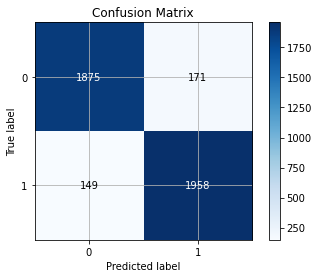

In [0]:
plot_cmat(y_test, y_pred3.round())